<a href="https://colab.research.google.com/github/gtgupta/test-colab/blob/main/Microkinetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

In [54]:
def main():
    
    print('XCSTR = ',xcstr)
    print('Conversion = ',(FLAin - FLA) / FLAin * 100.0)
    print('TOF = ',xout)
    print('xLA= ,xAA= ,xH2O= ,xv= ',xLA, xAA,xH2O,xv)
    print('x_sum = ',xv + xLA + xAA + xH2O)
    print('z1= ,z2= ,z3= ,z4= ,ztot= ',z1,z2,z3,z4,ztot)
    print('ztest = ',z1 * z2 * z3 * z4 / ztot)
    #print('N-balance = ',2.0 * FN2 + FNH3 - 2.0 * FN2in - FNH3in)
    #print('H-balance = ',2.0 * FH2 + 3.0 * FNH3 - 2.0 * FH2in - 3.0 * FNH3in)

    plt.figure(1)
    t, y = solve_odes()
    plt.plot(t, y[:,0]/FLAin *100)
    plt.ylim(0, 3)
    plt.xlim(0, 1)
    plt.xlabel('Length of Reactor or Integration Time')
    plt.ylabel('Conversion')
    
    plt.figure(2)
    plt.plot(t,y[:,1] , 'b', label='xLA')
    plt.plot(t,y[:,2] , 'r', label='xAA')
    plt.plot(t,y[:,3] , 'g', label='xH2O')
    xvplot = (1.0 - y[:,1] - y[:,2] - y[:,3])
    plt.plot(t,xvplot, 'y', label='xv')
    plt.xlim(0, 1)
    plt.xlabel('Length of Reactor or Integration Time')
    plt.ylabel('Coverages')
    plt.legend(loc='best')

In [55]:
# Reaction feed and conditions
xcstr = 1.0
sites = 10                           # micro-mol
flowin = 60                           # cm3(STP)/min
Fin = flowin/60.0/22400*1000000/sites
FLAin = Fin
FAAin = 0.0001
FH2Oin = 0.0001
Finert = Fin - FLAin - FAAin - FH2Oin

T = 623.15    # temperature in K

In [56]:
# Intial conditions
xin = 0
xLAin = 0.1
xAAin = 0.1
xH2Oin = 0.1
    
kf1 = 6.43         # unit Pa-1.site-1.sec-1
K1 = 1.47e-3
km1 = kf1/K1
kf2 = 4.86e-5
K2 = 2.63e5
km2 = kf2/K2
kf3 = 7.19
K3 = 1.71e3
km3 = kf3/K3
kf4 = 1.44e1
K4 = 1.21e6
km4 = kf4/K4
Keq = K1 * K2 * K3 * K4

In [57]:
def solve_odes():
    """
    Time-integrate chemo-kinetic system
    """
    y0 = [xin,xLAin,xAAin,xH2Oin]
    t0 = 0
    t1 = 1   # total integration time
    pt = 100
    pLA = pt
    pAA = 0.0
    pH2O = 0.0
    
    # construct ODE solver
    r = ode(dydt).set_integrator('vode', method='bdf', 
           atol=1e-8, rtol=1e-8, nsteps=1000, with_jacobian=True)
    r.set_initial_value(y0, t0).set_f_params([pLA,pAA,pH2O])
    
    # integrate on a logaritmic scale
    xx = np.linspace(-12.0, np.log10(t1), int((np.log10(t1) + 12.0) * 100))
    yy = []
    tt = []
    for i in xx:
        tnew = 10.0**i
        tt.append(tnew)
        yy.append(r.integrate(tnew))    
        
    return tt, np.matrix(yy)

In [58]:
#final output
t, y = solve_odes()
olength = len(y)
pt = 100
xout = y[olength-1,0]
FLA = FLAin - y[olength-1,0]
FAA = FAAin + y[olength-1,0]
FH2O = FH2Oin + y[olength-1,0]
Ftot = FLA + FAA + FH2O + Finert
pLA = FLA/Ftot * pt
pAA = FAA/Ftot * pt
pH2O = FH2O/Ftot * pt


xLA = y[olength-1,1]
xAA = y[olength-1,2]
xH2O = y[olength-1,3]
xv = (1.0 - xLA - xAA - xH2O)

rate1 = kf1 * pLA * xv  - km1 * xLA
rate2 = kf2 * xLA - km2 * xAA * xH2O
rate3 = kf3 * xAA - km3 * pAA * xv
rate4 = kf4 * xH2O - km4 * pH2O * xv

z1 = (km1 * xLA) / (kf1 * pLA * xv)
z2 = (km2 * xAA * xH2O) / (kf2 * xLA)
z3 = (km3 * pAA * xv) / (kf3 * xAA)
z4 = (km4 * pH2O * xv) / (kf4 * xH2O)
ztot = pAA * pH2O / pLA / Keq

In [ ]:
def dydt(t, y, params):
    """
    Set of ordinary differential equations
    """
    """
    Elementary steps
    
      LA(g) + *   <-->  LA*                (1)           
        LA* + *   <-->  AA* + H2O*         (2)
        AA*       <-->  AA(g) + *          (3) 
        H2O*      <--> H2O(g) + *          (4)
    """
    pLA = params[0]
    pAA = params[1]
    pH2O = params[2]
    
    pt = 100
    
    dydt = np.zeros(4)
    
    FLA = FLAin - y[0]
    FAA = FAAin + y[0]
    FH2O = FH2Oin + y[0]
    Ftot = FLA + FAA + FH2O + Finert
    pLA = FLA/Ftot * pt
    pAA = FAA/Ftot * pt
    pH2O = FH2O/Ftot * pt
    
    xLA = y[1]
    xAA = y[2]
    xH2O = y[3]
    xv = (1.0 - xLA - xAA - xH2O)
    
    # collect similar terms in new variables    
    rate1 = kf1 * pLA * xv  - km1 * xLA
    rate2 = kf2 * xLA - km2 * xAA * xH2O
    rate3 = kf3 * xAA - km3 * pAA * xv
    rate4 = kf4 * xH2O - km4 * pH2O * xv
    
    dydt[0] = rate1+(-y[0]) * xcstr
    dydt[1] = rate1 - rate2
    dydt[2] = rate2 - rate3
    dydt[3] = rate2 - rate4
    
    return dydt

XCSTR =  1.0
Conversion =  0.25498844112833297
TOF =  0.01138341255037187
xLA= ,xAA= ,xH2O= ,xv=  0.12756266963082485 0.00022564340055098938 6.849195875181433e-07 0.8722110020490367
x_sum =  1.0
z1= ,z2= ,z3= ,z4= ,ztot=  0.9999988729698878 4.606625152186582e-15 0.5799837271984365 0.27002849651082556 8.27153727899248e-16
ztest =  0.8722110020490366


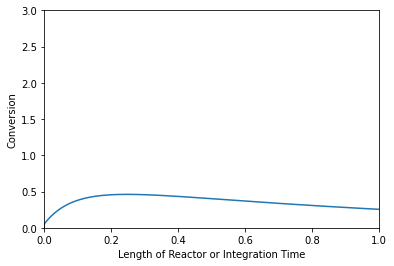

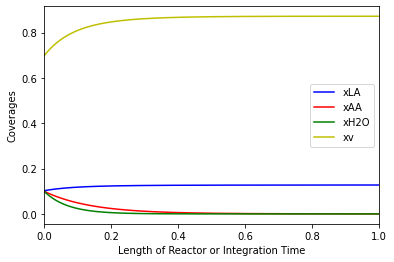

In [59]:
if __name__ == '__main__':
    main()